In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
from pprint import pprint
import collections
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib import colors
from matplotlib import cm as CM

import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
from scipy.stats import gaussian_kde
from scipy import stats
import tensorflow as tf

project_root = '..'
sys.path.append(project_root)

from sleeprnn.nn.spectrum import compute_wavelets, apply_wavelets_rectangular, compute_wavelets_noisy
from sleeprnn.helpers import reader, plotter, printer, misc, performer
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import metrics
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.common import constants, pkeys, viz
from sleeprnn.common.optimal_thresholds import OPTIMAL_THR_FOR_CKPT_DICT

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

project_root = '..'
sys.path.append(project_root)

RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')
viz.notebook_full_width()

%matplotlib inline

/home/ntapia/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ntapia/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ntapia/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ntapia/miniconda3/envs/tf/lib/python3.6/site-pack

In [2]:
general_lw = 1.0
signal_lw = 0.8
general_color = viz.GREY_COLORS[9]
signal_color = viz.GREY_COLORS[7]
custom_color = viz.PALETTE['blue'] # viz.PALETTE['cyan'] # viz.PALETTE['blue']
ss_color = viz.PALETTE['blue']
kc_color = viz.PALETTE['green']
pred_color = viz.PALETTE['red']

In [3]:
subject_id = 1
which_kc_stamp = 195
left_context = -7#-2#4
right_context = 27#12#6

dataset = reader.load_dataset(constants.MASS_SS_NAME)
signal = dataset.get_subject_signal(subject_id=subject_id, normalize_clip=False)
stamps_ss = dataset.get_subject_stamps(subject_id=subject_id)
dataset = reader.load_dataset(constants.MASS_KC_NAME)
stamps_kc = dataset.get_subject_stamps(subject_id=subject_id)
fs = dataset.fs

print('%d SS stamps.' % stamps_ss.shape[0])
print('%d KC stamps.' % stamps_kc.shape[0])

segment_size = left_context + right_context
central_sample = stamps_kc[which_kc_stamp, :].mean()
start_sample = int(central_sample - fs * left_context)
end_sample = int(central_sample + fs * right_context)

segment_stamps_ss = utils.filter_stamps(stamps_ss, start_sample, end_sample)
segment_stamps_kc = utils.filter_stamps(stamps_kc, start_sample, end_sample)
segment_signal = signal[start_sample:end_sample]
time_axis = np.arange(start_sample, end_sample) / fs

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
Mean FFT Scaling of non-testing set: 1.5594099147386842
Per subject FFT scaling / Mean:
S01: 1.0215
S02: 1.0696
S03: 1.0474
S05: 1.0631
S06: 0.9940
S07: 0.9877
S09: 0.9348
S10: 0.8341
S11: 1.0459
S12: 0.7592
S13: 1.0895
S14: 0.9727
S17: 0.9233
S18: 0.9265
S19: 1.2431
Using Custom Scaling Dict
S01: 1.0000
S02: 1.0000
S03: 1.0000
S05: 1.0000
S06: 1.0000
S07: 1.0000
S09: 1.0000
S10: 1.0000
S11: 1.0000
S12: 1.0000
S13: 1.0000
S14: 1.0000
S17: 1.0000
S18: 1.0000
S19: 1.0000
Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_kc with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
1044 SS stamps.
409 KC stamps.


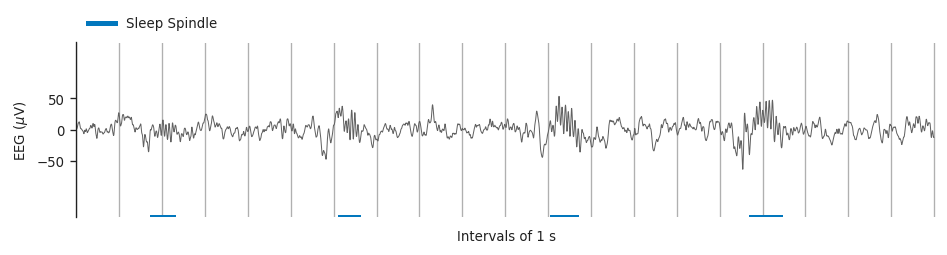

In [4]:
dpi = 120
y_max = 140
y_min = -140
figsize = (8, 2)
alpha = 1
linewidth_mark = 3
ss_correction_right = -0.1

fig, ax = plt.subplots(1, 1, dpi=dpi, figsize=figsize)

ax.plot(time_axis, segment_signal, linewidth=0.6, color=signal_color)
stamp_label_used = False
for stamp in segment_stamps_ss:
    if stamp_label_used:
        label = None
    else:
        label = 'Sleep Spindle'
        stamp_label_used = True
    ax.plot(
        [stamp[0] / fs, stamp[1] / fs + ss_correction_right], [y_min, y_min], label=label, 
        color=ss_color, linewidth=linewidth_mark)
    # ax.fill_between(
    #     stamp / fs, y_mark, -y_mark, 
    #     facecolor=ss_color, alpha=alpha, label=label)
stamp_label_used = False
for stamp in segment_stamps_kc:
    if stamp_label_used:
        label = None
    else:
        label = 'K-Complex'
        stamp_label_used = True
    ax.plot(
        stamp / fs, [y_min, y_min], label=label, 
        color=kc_color, linewidth=linewidth_mark)
    # ax.fill_between(
    #     stamp / fs, y_mark, -y_mark, 
    #     facecolor=kc_color, alpha=alpha, label=label)
ax.set_xlabel('Intervals of 1 s', fontsize=viz.FONTSIZE_GENERAL)
ax.set_ylabel('EEG ($\mu$V)', fontsize=viz.FONTSIZE_GENERAL)
ax.set_yticks([-50, 0, 50])
ax.set_xlim([time_axis[0], time_axis[-1]+0.05])
ax.set_ylim([y_min, y_max])
ax.set_xticks([])
ax.set_xticks(np.arange(time_axis[0], time_axis[-1]+0.1, 1), minor=True)
ax.grid(b=True, axis='x', which='minor')
lg = ax.legend(loc='lower left', bbox_to_anchor=(0,1), ncol=2, fontsize=viz.FONTSIZE_GENERAL, frameon=False)
ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', which='both',length=0)
for lh in lg.legendHandles:
    lh.set_alpha(min(2 * alpha, 1.0))

# Change color of plot
plt.setp(lg.get_texts(), color=general_color)
ax = plotter.set_axis_color(ax, general_color)
plt.tight_layout()

# plt.savefig("ss_kc_example.eps")

plt.show()

In [5]:
def raw_spectrum(signal, fs, pages, page_size):
    # Using FFT on whole page
    amp_all = []
    freq_all = []
    window_han = np.hanning(page_size)
    for page in pages:
        start_page = page * page_size
        end_page = start_page + page_size
        amp, freq = utils.power_spectrum(window_han * signal[start_page:end_page], fs)
        amp_all.append(amp)
        freq_all.append(freq)
    amp_all = np.stack(amp_all, axis=0).mean(axis=0)
    freq_all = np.stack(freq_all, axis=0).mean(axis=0)
    spectrum_page = np.stack([freq_all, amp_all], axis=1)
    
    # Using FFT on 2-seconds segments
    amp_all = []
    freq_all = []
    window_size = 2 * fs
    window_han = np.hanning(window_size)
    n_windows = int(2 * (page_size / window_size) - 1)
    for page in pages:
        start_page = page * page_size
        end_page = start_page + page_size
        segment_signal = signal[start_page:end_page]
        for i in range(n_windows):
            start_window = int(i * window_size / 2)
            end_window = start_window + window_size
            window_signal = segment_signal[start_window:end_window] * window_han
            padding = np.zeros(1 * fs)
            window_signal_extended = np.concatenate([padding, window_signal, padding])
            amp, freq = utils.power_spectrum(window_signal_extended, fs)
            amp_all.append(amp)
            freq_all.append(freq)
    amp_stft = np.stack(amp_all, axis=0)
    amp_all = np.stack(amp_all, axis=0).mean(axis=0)
    freq_all = np.stack(freq_all, axis=0).mean(axis=0)
    spectrum_window = np.stack([freq_all, amp_all], axis=1)
    
    results = {
        'spectrum_page': spectrum_page,
        'spectrum_window': spectrum_window,
        "spectrum_stft": amp_stft
    }
    return results


In [6]:
# Find Spectrum -- FFT
fft_result = raw_spectrum(segment_signal, fs, [0], segment_signal.size)

In [7]:
# Find Spectrum -- CWT
n_scales = 32
border_size = int(5 * fs)
segment_signal_cwt = signal[start_sample - border_size:end_sample + border_size]
tf.reset_default_graph()
inputs = tf.placeholder(
    dtype=tf.float32, shape=[None, segment_signal_cwt.size], name="feats_train_ph")
wavelets, frequencies = compute_wavelets(
    fb_list=[1.0],
    fs=fs,
    lower_freq=0.5,
    upper_freq=30,
    n_scales=n_scales,
    size_factor=1.0,
    flattening=False,
    trainable=False,
    name='cmorlet')
outputs = apply_wavelets_rectangular(
    inputs=inputs,
    wavelets=wavelets,
    border_crop=border_size,
    stride=1,
    name='cwt')
sess = tf.Session()
sess.run(tf.global_variables_initializer())
results, _ = sess.run([outputs, wavelets], feed_dict={inputs: [segment_signal_cwt]})
print(results.shape)
results_real = results[0, ..., 0]
results_imag = results[0, ..., 1]
cwt_magnitude = np.sqrt(results_real ** 2 + results_imag ** 2)



(1, 4000, 32, 2)


In [23]:
# Find Spectrum -- CWT Noisy
n_scales = 32
border_size = int(5 * fs)
segment_signal_cwt = signal[start_sample - border_size:end_sample + border_size]
tf.reset_default_graph()
inputs = tf.placeholder(
    dtype=tf.float32, shape=[None, segment_signal_cwt.size], name="feats_train_ph")
training_ph = tf.placeholder(tf.bool, name="training_ph")
wavelets, frequencies = compute_wavelets_noisy(
    fb_list=[1.0],
    fs=fs,
    lower_freq=0.5,
    upper_freq=30,
    n_scales=n_scales,
    size_factor=1.0,
    flattening=False,
    trainable=False,
    training_flag=training_ph,
    noise_intensity=0.05,
    name='cmorlet')
outputs = apply_wavelets_rectangular(
    inputs=inputs,
    wavelets=wavelets,
    border_crop=border_size,
    stride=1,
    name='cwt')
sess = tf.Session()
sess.run(tf.global_variables_initializer())
results, _ = sess.run([outputs, wavelets], feed_dict={inputs: [segment_signal_cwt], training_ph: True})
print(results.shape)
results_real = results[0, ..., 0]
results_imag = results[0, ..., 1]
cwt_magnitude_noisy_5 = np.sqrt(results_real ** 2 + results_imag ** 2)

CWT noise intensity: 0.05
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
Applying scale noise at CWT
(1, 4000, 32, 2)


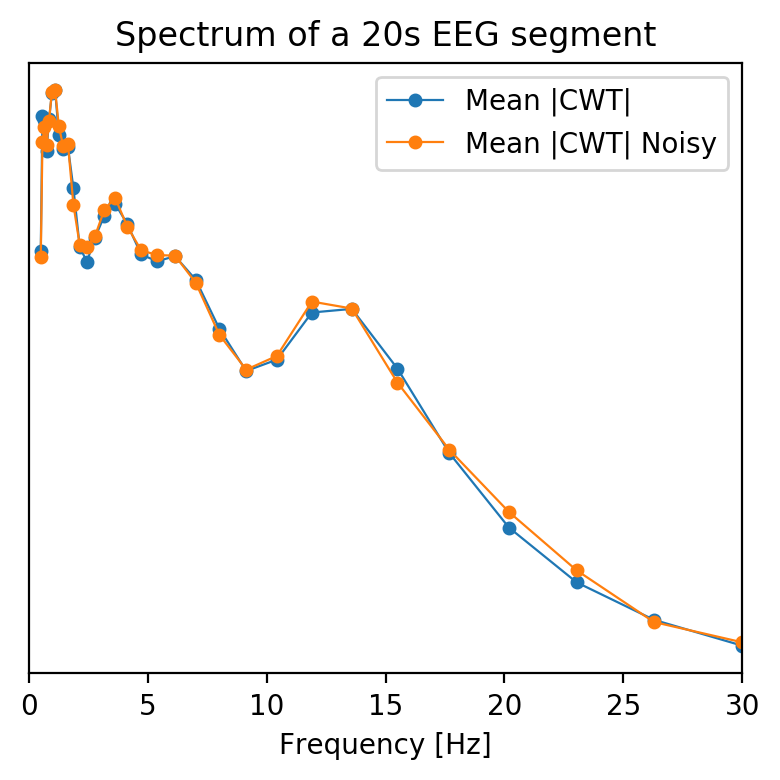

In [27]:
if False:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
    ax.plot(fft_result['spectrum_page'][:, 0], fft_result['spectrum_page'][:, 1], label="FFT", linewidth=0.8)
    ax.plot(fft_result['spectrum_window'][:, 0], fft_result['spectrum_window'][:, 1], label="Mean STFT")
    ax.legend(loc="upper right")
    ax.set_xlabel("Frequency [Hz]")
    ax.set_xlim([0.5, 30])
    plt.tight_layout()
    plt.show()

cwt_magnitude_mean = cwt_magnitude.mean(axis=0)
cwt_magnitude_mean_noisy = cwt_magnitude_noisy.mean(axis=0)
cwt_magnitude_mean_noisy_2 = cwt_magnitude_noisy_2.mean(axis=0)
cwt_magnitude_mean_noisy_3 = cwt_magnitude_noisy_3.mean(axis=0)
cwt_magnitude_mean_noisy_4 = cwt_magnitude_noisy_3.mean(axis=0)
cwt_magnitude_mean_noisy_5 = cwt_magnitude_noisy_3.mean(axis=0)
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
ax.plot(
    frequencies, cwt_magnitude_mean / cwt_magnitude_mean.max(), 
    label="Mean |CWT|", linewidth=.8, marker="o", markersize=4)
ax.plot(
    frequencies, cwt_magnitude_mean_noisy / cwt_magnitude_mean_noisy.max(), 
    label="Mean |CWT| Noisy", linewidth=.8, marker="o", markersize=4)
#ax.plot(
#    frequencies, cwt_magnitude_mean_noisy_2 / cwt_magnitude_mean_noisy_2.max(), 
#    label="Mean |CWT| Noisy (Sample 2)", linewidth=.8)
#ax.plot(
#    frequencies, cwt_magnitude_mean_noisy_3 / cwt_magnitude_mean_noisy_3.max(), 
#    label="Mean |CWT| Noisy (Sample 3)", linewidth=.8), marker="o", markersize=4
#ax.plot(
#    frequencies, cwt_magnitude_mean_noisy_4 / cwt_magnitude_mean_noisy_4.max(), 
#    label="Mean |CWT| Noisy (Sample 4)", linewidth=.8)
#ax.plot(
#    frequencies, cwt_magnitude_mean_noisy_5 / cwt_magnitude_mean_noisy_5.max(), 
#    label="Mean |CWT| Noisy (Sample 5)", linewidth=.8)
ax.set_yticks([])
#ax.plot(
#    fft_result['spectrum_window'][:, 0], fft_result['spectrum_window'][:, 1] / fft_result['spectrum_window'][:, 1].max(), 
#    label="Mean STFT")
ax.set_title("Spectrum of a 20s EEG segment")
ax.legend(loc="upper right")
ax.set_xlabel("Frequency [Hz]")
ax.set_xlim([0, 30])
plt.tight_layout()
plt.show()

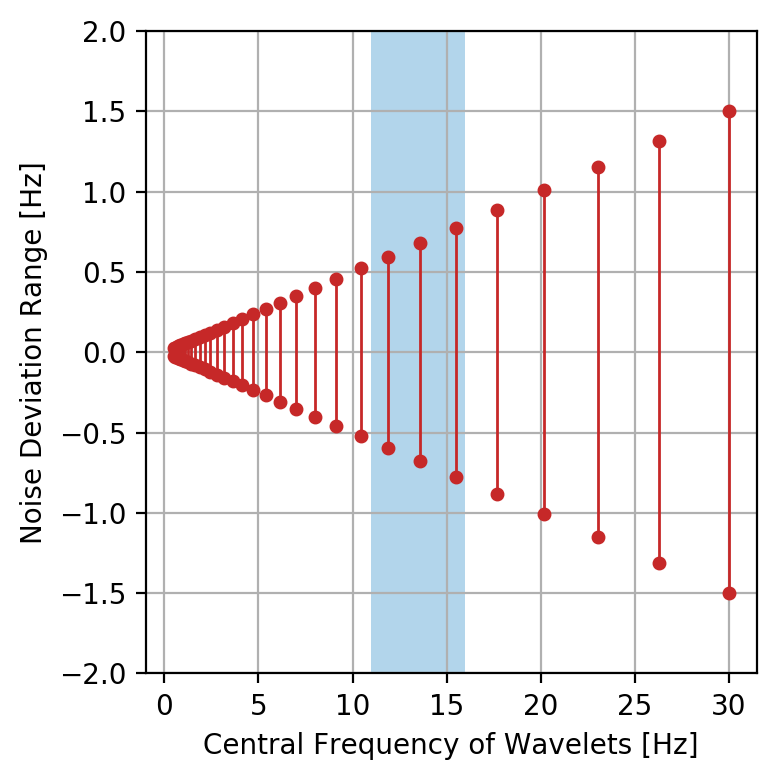

In [30]:
# measure maximum deviation due to noise
noise_intensity = 0.05
upper_freq = 30
lower_freq = 0.5
n_scales = 32
# Generate initial and last scale
s_0 = 1 / upper_freq
s_n = 1 / lower_freq
# Generate the array of scales
base = np.power(s_n / s_0, 1 / (n_scales - 1))
scales = s_0 * np.power(base, np.arange(n_scales))
scales = scales.astype(np.float32)
scales_high = scales / (1 - noise_intensity)
scales_low = scales / (1 + noise_intensity)
# Generate the frequency range
frequencies = 1 / scales
frequencies_low = 1 / scales_low
frequencies_high = 1 / scales_high
deviation_high = frequencies_high - frequencies
deviation_low = frequencies_low - frequencies

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
for i in range(n_scales):
    ax.plot(
        [frequencies[i], frequencies[i]], 
        [deviation_low[i], deviation_high[i]],
        marker="o", markersize=4, linewidth=1, color=viz.PALETTE["red"]
    )
ax.fill_between([11, 16], -3, 3, alpha=0.3, facecolor=viz.PALETTE["blue"])
#ax.plot(frequencies, deviation_low, marker="o", markersize=4)
#ax.plot(frequencies, deviation_high, marker="o", markersize=4)
ax.set_xlabel("Central Frequency of Wavelets [Hz]")
ax.set_ylabel("Noise Deviation Range [Hz]")
ax.set_ylim([-2, 2])
ax.grid()
plt.tight_layout()
plt.show()

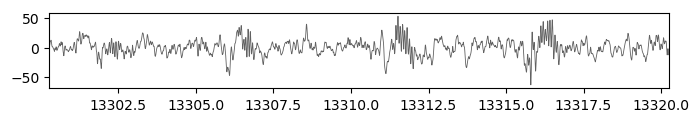

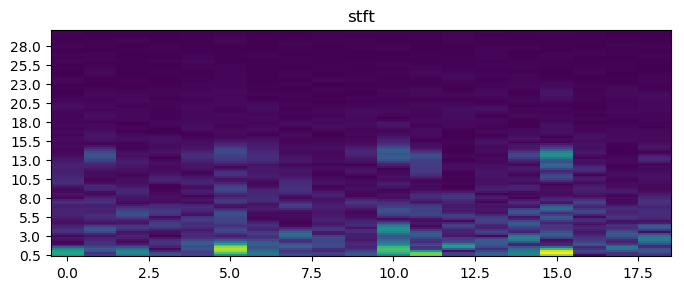

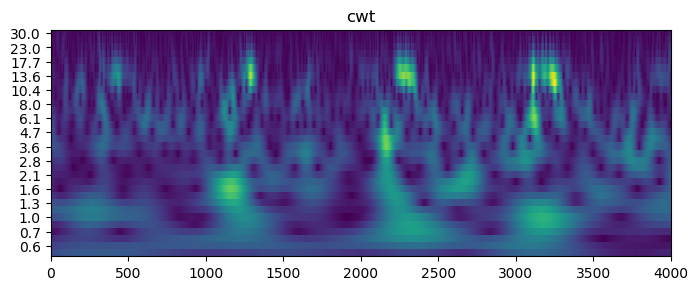

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 1), dpi=100)
ax.plot(time_axis, segment_signal, linewidth=0.6, color=signal_color)
ax.set_xlim([time_axis[0], time_axis[-1]])
plt.show()

# stft
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=100)
freq_axis = fft_result["spectrum_window"][:, 0]
band_loc = np.where((freq_axis >= 0.5) & (freq_axis <= 30))[0]
freq_axis_plot = freq_axis[band_loc]
stft_plot = fft_result["spectrum_stft"].T[band_loc, :]
ax.imshow(stft_plot, aspect="auto", origin="lower")
ax.set_yticks(np.arange(freq_axis_plot.size, step=10))
ax.set_yticklabels(freq_axis_plot[::10])
ax.set_title("stft")
plt.show()

# cwt
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=100)
ax.imshow(cwt_magnitude.T, aspect="auto", origin="upper")
ax.set_yticks(np.arange(frequencies.size, step=2))
ax.set_yticklabels(["%1.1f" % f for f in frequencies[::2]])
ax.set_title("cwt")
plt.show()